In [50]:
import numpy as np
import random
import pandas as pd
from keras.models import Model
from keras.layers import Input,Dense,LSTM,Conv1D,Activation
from keras import optimizers
import keras
import math as m

In [51]:
def input_vectors(time_series):
    splitted_data = []
    for i in range (0,time_series.shape[0] // 3 - 1):
        chunk = time_series[i*3:(i+1)*3]
        splitted_data.append(chunk.reshape(1,3,1))
    return np.vstack(splitted_data)
def prep_data(file_name):
    days_data = []
    with open(file_name) as f:
        for i, line in enumerate(f):
            if i:
                sequence =  float(line.rstrip().split(',')[-1])
                days_data.append(sequence)
    days_data = np.array(days_data[::-1])
    days_data -= days_data.min()
    days_data /= days_data.max()
    number_of_days = days_data.shape[0]
    n = number_of_days
    training = days_data[:-int(0.2*n)]
    testing = days_data[-int(0.2*n):]
    training_d = training[:-1]
    training_l = training[1:]
    testing_d = testing[:-1]
    testing_l = testing[1:]
    return input_vectors(training_d),input_vectors(training_l),input_vectors(testing_d), input_vectors(testing_l)

def reshaper(v):
    l = v.shape[0]
    return v.reshape(l, 1)

def subsample(l, y, n=1):
    start = random.randint(0, l.shape[0]- (n+1))
    subsample = l[start:start+n]
    suby = y[start: start+n]
    init = np.zeros((len(l) - n, 1))
    return np.concatenate([init, subsample], axis=0), np.concatenate([init, suby], axis=0)

In [52]:
def lstm():
    inp = Input(shape=(3, 1))
    x = LSTM(32, return_sequences=True)(inp)
    x = Dense(1, activation='relu')(x)
    return Model(inputs=inp, outputs=x)
def augment(xs, ys, times=5):
    d, ts, f = xs.shape
    aug_xs = []
    aug_ys = []
    for i in range(d):
        for j in range(times-1):
            random.seed(12)
            q = random.randint(0, ts - 1)
            ax, ay = subsample(xs[i], ys[i], n=q)
            aug_xs.append(ax.reshape(1, ts, f))
            aug_ys.append(ay.reshape(1, ts, f))
    aug_xs = np.vstack(aug_xs)
    aug_ys = np.vstack(aug_ys)
    xs = np.concatenate([xs, aug_xs], axis=0)
    ys = np.concatenate([ys, aug_ys], axis=0)
    return xs, ys

In [53]:
if __name__ == '__main__':
    trd, trl, ted, tel = prep_data('out.csv')
    
    trd, trl = augment(trd, trl, times=10)
    ted, tel = augment(ted, tel, times=10)

    np.save('trd.npy', trd)
    np.save('trl.npy', trl)
    np.save('ted.npy', ted)
    np.save('tel.npy', tel)
    
    epochs = 50
    lr = 1e-3
    decay = lr / epochs
    adam = keras.optimizers.Adam(lr=lr, decay=decay)
    adagrad = keras.optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0) 
    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    rms = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    
    model = lstm()

    model.summary()
    model.compile(loss='mse', optimizer=rms, metrics=['mse'])
    history=model.fit(trd, trl, batch_size=7, epochs=epochs, validation_data=[ted, tel], shuffle=True)
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3, 1)              0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 3, 32)             4352      
_________________________________________________________________
dense_11 (Dense)             (None, 3, 1)              33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Train on 5040 samples, validate on 1250 samples
Epoch 1/50
5040/5040 [==============================] - 4s 840us/step - loss: 0.0189 - mean_squared_error: 0.0189 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 2/50
5040/5040 [==============================] - 3s 511us/step - loss: 0.0088 - mean_squared_error: 0.0088 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 3/50
5040/5040 [==

5040/5040 [==============================] - 2s 444us/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0094 - val_mean_squared_error: 0.0094
Epoch 46/50
5040/5040 [==============================] - 2s 484us/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0094 - val_mean_squared_error: 0.0094
Epoch 47/50
5040/5040 [==============================] - 2s 441us/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0095 - val_mean_squared_error: 0.0095
Epoch 48/50
5040/5040 [==============================] - 2s 435us/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0095 - val_mean_squared_error: 0.0095
Epoch 49/50
5040/5040 [==============================] - 2s 430us/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0095 - val_mean_squared_error: 0.0095
Epoch 50/50
5040/5040 [==============================] - 2s 471us/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0094 - val_mean_squared_error: 0.0094


In [54]:
print(m.sqrt(0.0085))

0.09219544457292887


In [5]:
mse = history.history['mean_squared_error']
mse_pd = pd.DataFrame(mse)
mse_pd.to_csv('mse.csv',index=False)

In [59]:
history.history

{'loss': [0.018943587965178369,
  0.0088440961721062191,
  0.0087478899869488994,
  0.008687523173931469,
  0.0086319088515059168,
  0.0085828283759635977,
  0.008537938612345088,
  0.0085376824693311291,
  0.0085375160290924318,
  0.0085182578703905977,
  0.008522904694109457,
  0.0085044153738433829,
  0.0085275445321005665,
  0.0085044940563319769,
  0.0084890699577954368,
  0.0085221454766724498,
  0.0085084255686928775,
  0.0085000260108144075,
  0.0085119982603727197,
  0.0085180936443874904,
  0.0084853462665099265,
  0.0085219142108043239,
  0.0085006967072533569,
  0.0084938435690774996,
  0.0085034293177563489,
  0.0085061590376830677,
  0.0084901667665690187,
  0.0084700429546501251,
  0.0084837214440792903,
  0.0084885533279803992,
  0.0085031532718049772,
  0.0085142772289448967,
  0.0084733718915837621,
  0.0084991658045409074,
  0.0085180073774204675,
  0.0085117530948385436,
  0.0085100604084598474,
  0.0085039185460320573,
  0.0085052375355897103,
  0.00849297266734841

In [55]:
loss = history.history['loss']
lossdf = pd.DataFrame(loss)
lossdf.to_csv('loss.csv', index = False)

In [56]:
val_loss = history.history['val_loss']
val_lossdf = pd.DataFrame(val_loss)
val_lossdf.to_csv('valloss.csv', index=False)

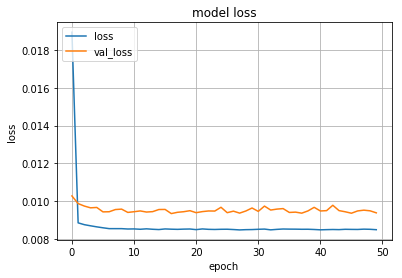

In [60]:
import matplotlib.pyplot as plt
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.grid()
plt.show()

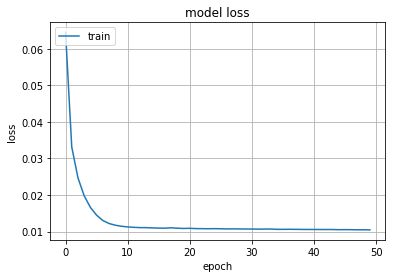

In [11]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [36]:
y=model.predict_on_batch(ted)

In [12]:
y.shape
ted.shape
prediction = []
ground_truth = []
for i in range (0,20):
    for j in range (0,13):
        prediction.append(y[i][j][0])
        ground_truth.append(ted[i][j][0])

NameError: name 'y' is not defined

In [64]:
y[0][0][0]

0.80438775

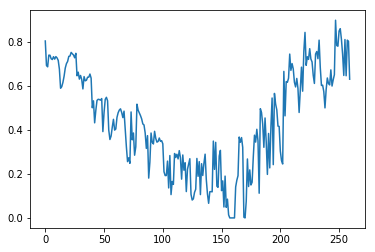

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(prediction)

In [73]:
prediction = pd.DataFrame(prediction)

In [75]:
prediction.to_csv('prediction.csv' , index=False)

In [76]:
ground_truth_df = pd.DataFrame(ground_truth)

In [78]:
ground_truth_df.to_csv('ground_truth.csv', index=False)